In [1]:
# Data Cleaning
import pandas as pd
from datetime import datetime

#Variable Selection
import itertools
from scipy.stats.stats import pearsonr, normaltest
from scipy.spatial.distance import correlation
import statsmodels.formula.api as smf

# Ridge Regression
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import time

# Lasso Regression - no new imports

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

### Data quality check
*By Aymen Lamsahel*

The code below visualizes the distribution of all the variables in the dataset, and their association with the response.

In [7]:
#...Distribution of continuous variables...#

In [8]:
#...Distribution of categorical variables...#

In [9]:
#...Association of the response with the predictors...#

### Data cleaning
*By Ben Caterine*

#### Airports Dataset

In [2]:
airports = pd.read_csv('data/airports.csv')
airports.columns = airports.columns.str.lower()
airports.head()

,iata_code,airport,city,state,country,latitude,longitude
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


#### Flights Dataset

In [3]:
flights = pd.read_csv('data/flights.csv')

/Applications/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
flights.columns = flights.columns.str.lower()

# merge flights with airports for origin
flights = flights.merge(right=airports, how='inner', left_on='origin_airport', right_on='iata_code')

flights.rename(columns={'latitude': 'origin_latitude', 'longitude': 'origin_longitude'}, inplace=True)

# merge flights with airports for destination
flights = flights.merge(right=airports, how='inner', left_on='destination_airport', right_on='iata_code',
                        suffixes=('_origin', '_destination'))

flights.rename(columns={'latitude': 'destination_latitude', 'longitude': 'destination_longitude'}, inplace=True)

flights.head()

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,...,country_origin,origin_latitude,origin_longitude,iata_code_destination,airport_destination,city_destination,state_destination,country_destination,destination_latitude,destination_longitude
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,USA,61.17432,-149.99619,SEA,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,45,...,USA,61.17432,-149.99619,SEA,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,45,...,USA,61.17432,-149.99619,SEA,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931
3,2015,1,1,4,AS,136,N431AS,ANC,SEA,135,...,USA,61.17432,-149.99619,SEA,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931
4,2015,1,1,4,AS,134,N464AS,ANC,SEA,155,...,USA,61.17432,-149.99619,SEA,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931


In [5]:
# remove columns for the stated reasons (primarily irrelvance or collinearity)
flights_clean = flights[flights.columns.difference([
    'year', # all are 2015
    'flight_number', # irrelevant
    'tail_number', # irrelevant
    'departure_time', # collinearity: scheduled_departure + departure_delay
    'wheels_off', # co: departure_time + taxi_out
    'elapsed_time', # co: scheduled_time + departure_delay
    'air_time', # co: elapsed_time - taxi_out - taxi_in
    'wheels_on', # co: arrival_time - taxi_in
    'arrival_time', # co: scheduled_arrival
    # leave in scheduled_arrival because of time change
    'arrival_delay', # co: departure_delay
    'diverted', # occurs after delay, can't be used to predict delay time
    'cancelled', # occurs after delay
    'cancellation_reason',
    'air_system_delay',
    'security_delay',
    'airline_delay',
    'late_aircraft_delay',
    'weather_delay',
    'iata_code_origin', 'iata_code_destination', # same as origin_airport
    'airport_origin', 'airport_destination', # airport already described in origin_airport
    'country_origin', 'country_destination' # all are USA
])]

In [6]:
flights_clean.head()

,airline,city_destination,city_origin,day,day_of_week,departure_delay,destination_airport,destination_latitude,destination_longitude,distance,...,origin_airport,origin_latitude,origin_longitude,scheduled_arrival,scheduled_departure,scheduled_time,state_destination,state_origin,taxi_in,taxi_out
0,AS,Seattle,Anchorage,1,4,-11.0,SEA,47.44898,-122.30931,1448,...,ANC,61.17432,-149.99619,430,5,205.0,WA,AK,4.0,21.0
1,AS,Seattle,Anchorage,1,4,-4.0,SEA,47.44898,-122.30931,1448,...,ANC,61.17432,-149.99619,509,45,204.0,WA,AK,4.0,17.0
2,DL,Seattle,Anchorage,1,4,-14.0,SEA,47.44898,-122.30931,1448,...,ANC,61.17432,-149.99619,515,45,210.0,WA,AK,4.0,25.0
3,AS,Seattle,Anchorage,1,4,NaN,SEA,47.44898,-122.30931,1448,...,ANC,61.17432,-149.99619,600,135,205.0,WA,AK,NaN,NaN
4,AS,Seattle,Anchorage,1,4,-15.0,SEA,47.44898,-122.30931,1448,...,ANC,61.17432,-149.99619,633,155,218.0,WA,AK,11.0,17.0


In [7]:
def time_to_minutes(n):
    # converts from HHMM time (written as number)
    # to number of minutes elapsed since midnight
    return (n // 100) * 60 + (n % 100)

In [8]:
# convert hhmm columns to time since midnight in minutes
flights_clean.scheduled_departure = flights_clean.scheduled_departure.apply(time_to_minutes)
flights_clean.scheduled_arrival = flights_clean.scheduled_arrival.apply(time_to_minutes)

/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [9]:
flights_clean.head()

,airline,city_destination,city_origin,day,day_of_week,departure_delay,destination_airport,destination_latitude,destination_longitude,distance,...,origin_airport,origin_latitude,origin_longitude,scheduled_arrival,scheduled_departure,scheduled_time,state_destination,state_origin,taxi_in,taxi_out
0,AS,Seattle,Anchorage,1,4,-11.0,SEA,47.44898,-122.30931,1448,...,ANC,61.17432,-149.99619,270,5,205.0,WA,AK,4.0,21.0
1,AS,Seattle,Anchorage,1,4,-4.0,SEA,47.44898,-122.30931,1448,...,ANC,61.17432,-149.99619,309,45,204.0,WA,AK,4.0,17.0
2,DL,Seattle,Anchorage,1,4,-14.0,SEA,47.44898,-122.30931,1448,...,ANC,61.17432,-149.99619,315,45,210.0,WA,AK,4.0,25.0
3,AS,Seattle,Anchorage,1,4,NaN,SEA,47.44898,-122.30931,1448,...,ANC,61.17432,-149.99619,360,95,205.0,WA,AK,NaN,NaN
4,AS,Seattle,Anchorage,1,4,-15.0,SEA,47.44898,-122.30931,1448,...,ANC,61.17432,-149.99619,393,115,218.0,WA,AK,11.0,17.0


In [10]:
# add column for nth day of year (in addition to month/day columns)
def day_counter(row):
    # convert from month and day to nth day of year (i.e. feb 1 -> 32)
    return (datetime(year=2015, month=row.month, day=row.day) - datetime(year=2014, month=12, day=31)).days

In [11]:
flights_clean['day_of_year'] = flights_clean.apply(day_counter, axis=1)

<ipython-input-11-378aa3fec5ad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_clean['day_of_year'] = flights_clean.apply(day_counter, axis=1)


In [12]:
flights_clean.head()

,airline,city_destination,city_origin,day,day_of_week,departure_delay,destination_airport,destination_latitude,destination_longitude,distance,...,origin_latitude,origin_longitude,scheduled_arrival,scheduled_departure,scheduled_time,state_destination,state_origin,taxi_in,taxi_out,day_of_year
0,AS,Seattle,Anchorage,1,4,-11.0,SEA,47.44898,-122.30931,1448,...,61.17432,-149.99619,270,5,205.0,WA,AK,4.0,21.0,1
1,AS,Seattle,Anchorage,1,4,-4.0,SEA,47.44898,-122.30931,1448,...,61.17432,-149.99619,309,45,204.0,WA,AK,4.0,17.0,1
2,DL,Seattle,Anchorage,1,4,-14.0,SEA,47.44898,-122.30931,1448,...,61.17432,-149.99619,315,45,210.0,WA,AK,4.0,25.0,1
3,AS,Seattle,Anchorage,1,4,NaN,SEA,47.44898,-122.30931,1448,...,61.17432,-149.99619,360,95,205.0,WA,AK,NaN,NaN,1
4,AS,Seattle,Anchorage,1,4,-15.0,SEA,47.44898,-122.30931,1448,...,61.17432,-149.99619,393,115,218.0,WA,AK,11.0,17.0,1


In [13]:
flights_clean.loc[0]

airline                         AS
city_destination           Seattle
city_origin              Anchorage
day                              1
day_of_week                      4
departure_delay              -11.0
destination_airport            SEA
destination_latitude      47.44898
destination_longitude   -122.30931
distance                      1448
month                            1
origin_airport                 ANC
origin_latitude           61.17432
origin_longitude        -149.99619
scheduled_arrival              270
scheduled_departure              5
scheduled_time               205.0
state_destination               WA
state_origin                    AK
taxi_in                        4.0
taxi_out                      21.0
day_of_year                      1
Name: 0, dtype: object

In [14]:
flights_clean.dtypes

airline                   object
city_destination          object
city_origin               object
day                        int64
day_of_week                int64
departure_delay          float64
destination_airport       object
destination_latitude     float64
destination_longitude    float64
distance                   int64
month                      int64
origin_airport            object
origin_latitude          float64
origin_longitude         float64
scheduled_arrival          int64
scheduled_departure        int64
scheduled_time           float64
state_destination         object
state_origin              object
taxi_in                  float64
taxi_out                 float64
day_of_year                int64
dtype: object

#### Temperatures Dataset

In [15]:
temps = pd.read_csv('data/city_temperature.csv')
temps

/Applications/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9
...,...,...,...,...,...,...,...,...
2906322,North America,US,Additional Territories,San Juan Puerto Rico,7,27,2013,82.4
2906323,North America,US,Additional Territories,San Juan Puerto Rico,7,28,2013,81.6
2906324,North America,US,Additional Territories,San Juan Puerto Rico,7,29,2013,84.2
2906325,North America,US,Additional Territories,San Juan Puerto Rico,7,30,2013,83.8


In [16]:
temps.columns = temps.columns.str.lower()
temps_clean = temps[temps.country == 'US'][temps.year == 2015]
temps_clean.drop(columns=['region', 'country', 'state', 'year'], inplace=True)
temps_clean

<ipython-input-16-7d51f5c258f8>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temps_clean = temps[temps.country == 'US'][temps.year == 2015]


,city,month,day,avgtemperature
1458295,Birmingham,1,1,40.4
1458296,Birmingham,1,2,45.0
1458297,Birmingham,1,3,56.6
1458298,Birmingham,1,4,56.9
1458299,Birmingham,1,5,39.8
...,...,...,...,...
2897940,Cheyenne,12,27,6.9
2897941,Cheyenne,12,28,11.8
2897942,Cheyenne,12,29,13.2
2897943,Cheyenne,12,30,11.8


In [17]:
cities = temps_clean.city.unique()

In [18]:
present = flights_clean.city_origin.apply(lambda city: city in cities)

In [19]:
present.mean()

0.708105549798853

In [20]:
flights_cities = flights_clean.city_origin.unique()

In [21]:
# rename temps cities to match up with their names in flights
# i.e., Washington Dulles airport is in Chantilly, VA
renames = {
    'Washington DC': 'Chantilly',
    'Tampa St. Petersburg': 'Tampa',
    'Minneapolis St. Paul': 'Minneapolis',
    'New York City': 'New York',
    'Raleigh Durham': 'Raleigh',
    'Akron Canton': 'Akron',
    'Cincinnati': 'Covington',
    'Rhode Island': 'Providence',
    'Dallas Ft Worth': 'Dallas-Fort Worth'
}

In [22]:
temps_clean = temps_clean.replace(renames)
temps_clean

,city,month,day,avgtemperature
1458295,Birmingham,1,1,40.4
1458296,Birmingham,1,2,45.0
1458297,Birmingham,1,3,56.6
1458298,Birmingham,1,4,56.9
1458299,Birmingham,1,5,39.8
...,...,...,...,...
2897940,Cheyenne,12,27,6.9
2897941,Cheyenne,12,28,11.8
2897942,Cheyenne,12,29,13.2
2897943,Cheyenne,12,30,11.8


In [23]:
temps_clean = pd.concat([
    temps_clean,
    temps_clean.loc[temps_clean.city == 'Dallas-Fort Worth'].replace({'Dallas-Fort Worth': 'Dallas'})
], ignore_index=True)

In [24]:
cities = temps_clean.city.unique()

In [25]:
present = flights_clean.city_origin.apply(lambda city: city in cities)

In [26]:
present.mean()

0.8528817453272264

In [27]:
flights_clean.head()

,airline,city_destination,city_origin,day,day_of_week,departure_delay,destination_airport,destination_latitude,destination_longitude,distance,...,origin_latitude,origin_longitude,scheduled_arrival,scheduled_departure,scheduled_time,state_destination,state_origin,taxi_in,taxi_out,day_of_year
0,AS,Seattle,Anchorage,1,4,-11.0,SEA,47.44898,-122.30931,1448,...,61.17432,-149.99619,270,5,205.0,WA,AK,4.0,21.0,1
1,AS,Seattle,Anchorage,1,4,-4.0,SEA,47.44898,-122.30931,1448,...,61.17432,-149.99619,309,45,204.0,WA,AK,4.0,17.0,1
2,DL,Seattle,Anchorage,1,4,-14.0,SEA,47.44898,-122.30931,1448,...,61.17432,-149.99619,315,45,210.0,WA,AK,4.0,25.0,1
3,AS,Seattle,Anchorage,1,4,NaN,SEA,47.44898,-122.30931,1448,...,61.17432,-149.99619,360,95,205.0,WA,AK,NaN,NaN,1
4,AS,Seattle,Anchorage,1,4,-15.0,SEA,47.44898,-122.30931,1448,...,61.17432,-149.99619,393,115,218.0,WA,AK,11.0,17.0,1


In [28]:
temps_clean.head()

,city,month,day,avgtemperature
0,Birmingham,1,1,40.4
1,Birmingham,1,2,45.0
2,Birmingham,1,3,56.6
3,Birmingham,1,4,56.9
4,Birmingham,1,5,39.8


In [29]:
# merge flights with temps now that we've cleaned temps so that most flights match up
flights_clean = flights_clean.merge(right=temps_clean, how='inner', left_on=['city_origin', 'month', 'day'],
                                    right_on=['city', 'month', 'day'])

flights_clean.rename(columns={'avgtemperature': 'origin_temperature'}, inplace=True)

In [30]:
flights_clean.drop(columns=[])

,airline,city_destination,city_origin,day,day_of_week,departure_delay,destination_airport,destination_latitude,destination_longitude,distance,...,scheduled_arrival,scheduled_departure,scheduled_time,state_destination,state_origin,taxi_in,taxi_out,day_of_year,city,origin_temperature
0,AS,Seattle,Anchorage,1,4,-11.0,SEA,47.44898,-122.30931,1448,...,270,5,205.0,WA,AK,4.0,21.0,1,Anchorage,35.2
1,AS,Seattle,Anchorage,1,4,-4.0,SEA,47.44898,-122.30931,1448,...,309,45,204.0,WA,AK,4.0,17.0,1,Anchorage,35.2
2,DL,Seattle,Anchorage,1,4,-14.0,SEA,47.44898,-122.30931,1448,...,315,45,210.0,WA,AK,4.0,25.0,1,Anchorage,35.2
3,AS,Seattle,Anchorage,1,4,NaN,SEA,47.44898,-122.30931,1448,...,360,95,205.0,WA,AK,NaN,NaN,1,Anchorage,35.2
4,AS,Seattle,Anchorage,1,4,-15.0,SEA,47.44898,-122.30931,1448,...,393,115,218.0,WA,AK,11.0,17.0,1,Anchorage,35.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4681698,NK,Ft. Lauderdale,Atlantic City,31,4,-5.0,FLL,26.07258,-80.15275,977,...,1365,1207,158.0,FL,NJ,9.0,9.0,365,Atlantic City,54.0
4681699,NK,Tampa,Atlantic City,31,4,-2.0,TPA,27.97547,-82.53325,913,...,958,801,157.0,FL,NJ,7.0,11.0,365,Atlantic City,54.0
4681700,NK,Ft. Myers,Atlantic City,31,4,2.0,RSW,26.53617,-81.75517,982,...,549,380,169.0,FL,NJ,4.0,11.0,365,Atlantic City,54.0
4681701,NK,Ft. Myers,Atlantic City,31,4,6.0,RSW,26.53617,-81.75517,982,...,1200,1040,160.0,FL,NJ,3.0,7.0,365,Atlantic City,54.0


In [31]:
# same for destination temps
flights_clean = flights_clean.merge(right=temps_clean, how='inner', left_on=['city_destination', 'month', 'day'],
                    right_on=['city', 'month', 'day'])

flights_clean.rename(columns={'avgtemperature': 'destination_temperature'}, inplace=True)

In [32]:
flights_clean

,airline,city_destination,city_origin,day,day_of_week,departure_delay,destination_airport,destination_latitude,destination_longitude,distance,...,scheduled_time,state_destination,state_origin,taxi_in,taxi_out,day_of_year,city_x,origin_temperature,city_y,destination_temperature
0,AS,Seattle,Anchorage,1,4,-11.0,SEA,47.44898,-122.30931,1448,...,205.0,WA,AK,4.0,21.0,1,Anchorage,35.2,Seattle,32.9
1,AS,Seattle,Anchorage,1,4,-4.0,SEA,47.44898,-122.30931,1448,...,204.0,WA,AK,4.0,17.0,1,Anchorage,35.2,Seattle,32.9
2,DL,Seattle,Anchorage,1,4,-14.0,SEA,47.44898,-122.30931,1448,...,210.0,WA,AK,4.0,25.0,1,Anchorage,35.2,Seattle,32.9
3,AS,Seattle,Anchorage,1,4,NaN,SEA,47.44898,-122.30931,1448,...,205.0,WA,AK,NaN,NaN,1,Anchorage,35.2,Seattle,32.9
4,AS,Seattle,Anchorage,1,4,-15.0,SEA,47.44898,-122.30931,1448,...,218.0,WA,AK,11.0,17.0,1,Anchorage,35.2,Seattle,32.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4099037,EV,Roanoke,Atlanta,27,5,77.0,ROA,37.32547,-79.97543,357,...,83.0,VA,GA,3.0,9.0,331,Atlanta,59.7,Roanoke,49.4
4099038,EV,Roanoke,Atlanta,27,5,-6.0,ROA,37.32547,-79.97543,357,...,83.0,VA,GA,5.0,21.0,331,Atlanta,59.7,Roanoke,49.4
4099039,DL,Roanoke,Atlanta,27,5,-1.0,ROA,37.32547,-79.97543,357,...,83.0,VA,GA,6.0,22.0,331,Atlanta,59.7,Roanoke,49.4
4099040,EV,Allentown,Atlanta,19,6,88.0,ABE,40.65236,-75.44040,692,...,113.0,PA,GA,3.0,22.0,353,Atlanta,37.8,Allentown,35.6


In [33]:
flights_clean.loc[0]

airline                           AS
city_destination             Seattle
city_origin                Anchorage
day                                1
day_of_week                        4
departure_delay                -11.0
destination_airport              SEA
destination_latitude        47.44898
destination_longitude     -122.30931
distance                        1448
month                              1
origin_airport                   ANC
origin_latitude             61.17432
origin_longitude          -149.99619
scheduled_arrival                270
scheduled_departure                5
scheduled_time                 205.0
state_destination                 WA
state_origin                      AK
taxi_in                          4.0
taxi_out                        21.0
day_of_year                        1
city_x                     Anchorage
origin_temperature              35.2
city_y                       Seattle
destination_temperature         32.9
Name: 0, dtype: object

In [34]:
flights_clean.drop(columns=['city_destination', 'city_origin', 'city_x', 'city_y'], inplace=True)

In [35]:
flights_clean.loc[0]

airline                           AS
day                                1
day_of_week                        4
departure_delay                -11.0
destination_airport              SEA
destination_latitude        47.44898
destination_longitude     -122.30931
distance                        1448
month                              1
origin_airport                   ANC
origin_latitude             61.17432
origin_longitude          -149.99619
scheduled_arrival                270
scheduled_departure                5
scheduled_time                 205.0
state_destination                 WA
state_origin                      AK
taxi_in                          4.0
taxi_out                        21.0
day_of_year                        1
origin_temperature              35.2
destination_temperature         32.9
Name: 0, dtype: object

In [36]:
flights_clean.isna().sum()

airline                        0
day                            0
day_of_week                    0
departure_delay            63038
destination_airport            0
destination_latitude           0
destination_longitude          0
distance                       0
month                          0
origin_airport                 0
origin_latitude                0
origin_longitude               0
scheduled_arrival              0
scheduled_departure            0
scheduled_time                 3
state_destination              0
state_origin                   0
taxi_in                    67123
taxi_out                   65176
day_of_year                    0
origin_temperature             0
destination_temperature        0
dtype: int64

In [37]:
flights_clean.dropna(inplace=True)

In [38]:
flights_clean.isna().sum()

airline                    0
day                        0
day_of_week                0
departure_delay            0
destination_airport        0
destination_latitude       0
destination_longitude      0
distance                   0
month                      0
origin_airport             0
origin_latitude            0
origin_longitude           0
scheduled_arrival          0
scheduled_departure        0
scheduled_time             0
state_destination          0
state_origin               0
taxi_in                    0
taxi_out                   0
day_of_year                0
origin_temperature         0
destination_temperature    0
dtype: int64

### Data preparation
*By Ben Caterine*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Write out to CSV the results of the cleaned flights dataset for importing in other modeling files.
2. Make a dataset with dummy variables for all categorical and write to CSV.
3. Get the subset of categorical levels which were significant and select only these to append to the numerical columns. Put this in another CSV file. We can use this to conteract the dummies file being too large.

In [39]:
flights_clean.to_csv('data/flights_clean.csv', index=False)

In [40]:
# dummy variable dataset out of categorical columns
flights_clean_numerical = pd.get_dummies(flights_clean)

In [41]:
flights_clean_numerical.to_csv('data/flights_clean_numerical.csv', index=False)

In [42]:
# subset dummy columns with only those significant in the base model
columns_subset = \
    list(flights_clean.columns.difference(['airline', 'destination_airport',
                                     'origin_airport', 'state_destination', 'state_origin']))
columns_subset += [
    'airline_AS', 'airline_NK', 'airline_UA',
    'destination_airport_BTV', 'destination_airport_DTW', 'destination_airport_FNT', 
    'origin_airport_CMH', 'origin_airport_IAD', 'origin_airport_LNK', 'origin_airport_RIC',
    'state_destination_MI', 'state_destination_VT', 'state_origin_NE'
]
flights_clean_numerical_significant = flights_clean_numerical[columns_subset]

In [43]:
flights_clean_numerical_significant.to_csv('data/flights_clean_numerical_significant.csv', index=False)

## Exploratory data analysis
*By Aymen Lamsahel*

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

## Developing the model

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

### Variable Selection: Best Subset Selection
*By Haneef Usmani*

To develop our model, we began with using variable selections methods we learned in class. First was best subset selection, which we were only able to run on a small sample, so couldn't make any reasonable inferences from it.

In [ ]:
flights_clean = pd.read_csv('flights_clean.csv')
flights = flights_clean.sample(10000, random_state=1) # only sampled 10000 since the dataset is too large

In [ ]:
train, test = train_test_split(flights, test_size=0.2)

In [ ]:
# drop all categorical variables from train
train_drop = train.drop(['airline', 'destination_airport', 'origin_airport', 'state_destination', 'state_origin'], axis=1)

In [ ]:
# create a copy for column names
X = train[['airline', 'day', 'day_of_week', 'destination_airport', 'destination_latitude', 'destination_longitude', 'distance', 'month', 'origin_airport', 'origin_latitude', 'origin_longitude', 'scheduled_arrival', 'scheduled_departure', 'scheduled_time', 'state_destination', 'state_origin', 'taxi_in', 'taxi_out', 'day_of_year', 'origin_temperature', 'destination_temperature']]
# take out all categorical variables
X = X.drop(['airline', 'destination_airport', 'origin_airport', 'state_destination', 'state_origin'], axis=1)

In [ ]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = smf.ols('departure_delay~' + '+'.join(predictor_subset),data = train_drop).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}
#Function to select the best model amongst all models with 'k' predictors
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [ ]:
#Function to select the best model amongst the best models for 'k' predictors, where k = 1,2,3,..
models_best = pd.DataFrame(columns=["Rsquared", "model"])
tic = time.time()
for i in range(1,1+X.shape[1]):
    models_best.loc[i] = getBest_model(i)
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 16 models on 1 predictors in 0.13599610328674316 seconds.
Processed 120 models on 2 predictors in 1.0080420970916748 seconds.
Processed 560 models on 3 predictors in 5.312252759933472 seconds.
Processed 1820 models on 4 predictors in 28.142412424087524 seconds.
Processed 4368 models on 5 predictors in 74.10345697402954 seconds.
Processed 8008 models on 6 predictors in 165.0827398300171 seconds.
Processed 11440 models on 7 predictors in 334.49633288383484 seconds.
Processed 12870 models on 8 predictors in 294.8457546234131 seconds.
Processed 11440 models on 9 predictors in 280.21948742866516 seconds.
Processed 8008 models on 10 predictors in 203.19205713272095 seconds.
Processed 4368 models on 11 predictors in 113.8034520149231 seconds.
Processed 1820 models on 12 predictors in 54.26904535293579 seconds.
Processed 560 models on 13 predictors in 18.86642026901245 seconds.
Processed 120 models on 14 predictors in 3.9664971828460693 seconds.
Processed 16 models on 15 predictors i

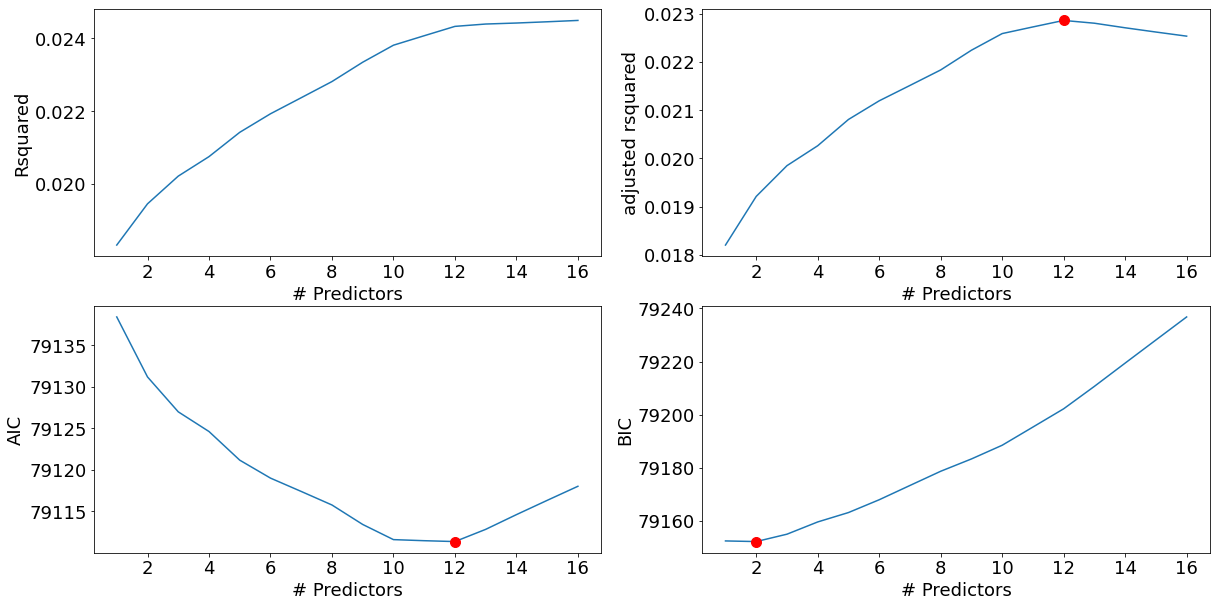

In [ ]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

In [ ]:
best_subset_model = models_best.loc[12,'model'] # best model based on AIC and adjusted R-squared
models_best.loc[12,'model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        departure_delay   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     16.60
Date:                Sun, 05 Mar 2023   Prob (F-statistic):           1.47e-35
Time:                        15:42:26   Log-Likelihood:                -39543.
No. Observations:                8000   AIC:                         7.911e+04
Df Residuals:                    7987   BIC:                         7.920e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 -50.7215     18.405     -2.756      0.006     -86.800     -14.643
day                         1.9916      0.615      3.241      0.001       0.787       3.196
day_of_week                -0.4078      0.193     -2.113      0.035      -0.786      -0.029
destination_latitude       -0.2349      0.083     -2.833      0.005      -0.398      -0.072
distance                    0.0009      0.001      1.450      0.147      -0.000       0.002
month                      61.5388     18.672      3.296      0.001      24.937      98.140
origin_latitude            -0.1085      0.075     -1.451      0.147      -0.255       0.038
scheduled_arrival           0.0032      0.002      1.863      0.062      -0.000       0.007
scheduled_departure         0.0137      0.002      7.586      0.000       0.010       0.017
taxi_in                     0.1408      0.063      2.238      0.025       0.018       0.264
taxi_out                    0.1133      0.039      2.882      0.004       0.036       0.190
day_of_year                -2.0241      0.613     -3.302      0.001      -3.226      -0.822
destination_temperature    -0.0918      0.027     -3.437      0.001      -0.144      -0.039
==============================================================================
Omnibus:                     9005.558   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1154585.390
Skew:                           5.712   Prob(JB):                         0.00
Kurtosis:                      60.734   Cond. No.                     1.08e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# variables most corrleated with departure delay
flights_clean.corr().departure_delay.sort_values(ascending=False)

departure_delay        1.000000
scheduled_departure    0.110211
scheduled_arrival      0.097523
taxi_out               0.058515
origin_longitude       0.031857
scheduled_time         0.027799
longitude              0.025585
distance               0.024106
taxi_in                0.012784
latitude               0.002190
day                   -0.000176
origin_latitude       -0.003755
day_of_week           -0.011510
day_of_year           -0.021968
month                 -0.021994
Name: departure_delay, dtype: float64

### Variable Selection: Forward Selection
*By Haneef Usmani*

Next, we ran forward selection which was alot of more suitable for this dataset due to the large number of observations and predictors

#### Numerical Data

First we performed forward selection only on numerical data since rnning on all predictors was not computationally feasible

In [ ]:
flight = pd.read_csv('flights_clean.csv')

In [ ]:
# split flight into train and test
train, test = train_test_split(flight, test_size=0.2)

In [ ]:
# drop all categorical variables from train
train_drop = train.drop(['airline', 'destination_airport', 'origin_airport', 'state_destination', 'state_origin'], axis=1)

In [ ]:
X = train[['airline', 'day', 'day_of_week', 'destination_airport', 'destination_latitude', 'destination_longitude', 'distance', 'month', 'origin_airport', 'origin_latitude', 'origin_longitude', 'scheduled_arrival', 'scheduled_departure', 'scheduled_time', 'state_destination', 'state_origin', 'taxi_in', 'taxi_out', 'day_of_year', 'origin_temperature', 'destination_temperature']]
# take out all categorical variables
X = X.drop(['airline', 'destination_airport', 'origin_airport', 'state_destination', 'state_origin'], axis=1)

In [ ]:
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = smf.ols('(departure_delay)~' + '+'.join(predictor_subset),data = train_drop).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [ ]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [ ]:
def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [ ]:
models_best = forward_selection()

Processed  16 models on 1 predictors in 8.12741208076477 seconds.
Processed  15 models on 2 predictors in 9.836007118225098 seconds.
Processed  14 models on 3 predictors in 10.54194450378418 seconds.
Processed  13 models on 4 predictors in 13.134437799453735 seconds.
Processed  12 models on 5 predictors in 16.103069305419922 seconds.
Processed  11 models on 6 predictors in 15.824368953704834 seconds.
Processed  10 models on 7 predictors in 15.907246589660645 seconds.
Processed  9 models on 8 predictors in 16.967482328414917 seconds.
Processed  8 models on 9 predictors in 16.88384771347046 seconds.
Processed  7 models on 10 predictors in 18.03978705406189 seconds.
Processed  6 models on 11 predictors in 15.867708444595337 seconds.
Processed  5 models on 12 predictors in 14.319014310836792 seconds.
Processed  4 models on 13 predictors in 13.070203065872192 seconds.
Processed  3 models on 14 predictors in 10.444658041000366 seconds.
Processed  2 models on 15 predictors in 7.89921641349792

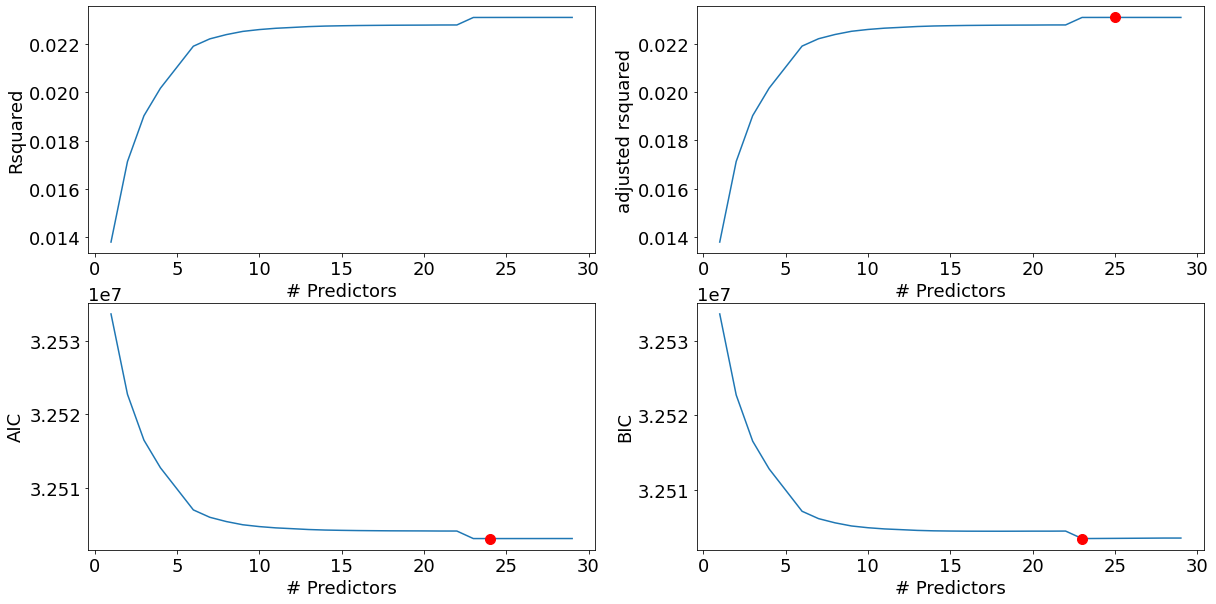

In [ ]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

In [ ]:
best_fwd_reg_model = models_best['model'][16]
best_fwd_reg_model.summary() # best model only with numerical variables

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        departure_delay   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     4079.
Date:                Sun, 05 Mar 2023   Prob (F-statistic):               0.00
Time:                        19:41:55   Log-Likelihood:            -1.6260e+07
No. Observations:             3225535   AIC:                         3.252e+07
Df Residuals:                 3225518   BIC:                         3.252e+07
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 -29.5943      1.040    -28.455      0.000     -31.633     -27.556
scheduled_departure         0.0120   9.76e-05    123.404      0.000       0.012       0.012
taxi_out                    0.2226      0.002     93.304      0.000       0.218       0.227
scheduled_arrival           0.0045   9.25e-05     48.475      0.000       0.004       0.005
day_of_week                -0.3540      0.010    -33.769      0.000      -0.375      -0.333
taxi_in                     0.0895      0.004     24.093      0.000       0.082       0.097
scheduled_time              0.0235      0.003      9.164      0.000       0.018       0.028
destination_longitude       0.0290      0.002     15.802      0.000       0.025       0.033
day_of_year                -1.1073      0.034    -32.533      0.000      -1.174      -1.041
origin_longitude            0.0098      0.002      4.397      0.000       0.005       0.014
origin_latitude            -0.1267      0.005    -25.486      0.000      -0.136      -0.117
origin_temperature         -0.0446      0.002    -22.249      0.000      -0.049      -0.041
destination_latitude       -0.0421      0.005     -8.458      0.000      -0.052      -0.032
distance                   -0.0018      0.000     -5.794      0.000      -0.002      -0.001
destination_temperature    -0.0052      0.002     -2.601      0.009      -0.009      -0.001
month                      33.6293      1.037     32.433      0.000      31.597      35.662
day                         1.1011      0.034     32.334      0.000       1.034       1.168
==============================================================================
Omnibus:                  4329464.821   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1962321007.046
Skew:                           7.451   Prob(JB):                         0.00
Kurtosis:                     122.912   Cond. No.                     1.11e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# print out all the predicotrs with their coefficients as a dataframe
pd.DataFrame(best_fwd_reg_model.params)
# rename the column names
pd.DataFrame(best_fwd_reg_model.params).rename(columns={0:'coefficients'})

,coefficients
Intercept,-29.594305
scheduled_departure,0.012039
taxi_out,0.222556
scheduled_arrival,0.004482
day_of_week,-0.353979
taxi_in,0.089497
scheduled_time,0.023468
destination_longitude,0.029021
day_of_year,-1.107288
origin_longitude,0.009818


In [ ]:
# model equation
print('departuredelay =')
for i in range(len(X.columns)):
    if best_fwd_reg_model.params[i] != 0:
        print('{:+3f} * {}'.format(best_fwd_reg_model.params[i], X.columns[i]))

departuredelay =
-29.594305 * day
+0.012039 * day_of_week
+0.222556 * destination_latitude
+0.004482 * destination_longitude
-0.353979 * distance
+0.089497 * month
+0.023468 * origin_latitude
+0.029021 * origin_longitude
-1.107288 * scheduled_arrival
+0.009818 * scheduled_departure
-0.126722 * scheduled_time
-0.044608 * taxi_in
-0.042067 * taxi_out
-0.001823 * day_of_year
-0.005194 * origin_temperature
+33.629274 * destination_temperature


In [ ]:
# RMSE
pred_price = (best_fwd_reg_model.predict(test))
np.sqrt(((pred_price - test.departure_delay)**2).mean())

37.35517169810643

### Numerical + Categorical Variables

Using an updated dataset of the numerical predictors and the significant categorical predictors from the baseline model, we wanted to see if we could improve our model 

In [ ]:
# dataset with only the significant categorical predicotrs from the base model
# could not run full dataset because it was too big
flights_numerical = pd.read_csv('flights_clean_numerical.csv')[[
    'airline_AS', 'airline_NK', 'airline_UA',
    'destination_airport_BTV', 'destination_airport_DTW', 'destination_airport_FNT', 
    'origin_airport_CMH', 'origin_airport_IAD', 'origin_airport_LNK', 'origin_airport_RIC',
    'state_destination_MI', 'state_destination_VT', 'state_origin_NE'
]]

In [ ]:
flight = flight[['departure_delay','airline', 'day', 'day_of_week', 'destination_airport', 'destination_latitude', 'destination_longitude', 'distance', 'month', 'origin_airport', 'origin_latitude', 'origin_longitude', 'scheduled_arrival', 'scheduled_departure', 'scheduled_time', 'state_destination', 'state_origin', 'taxi_in', 'taxi_out', 'day_of_year', 'origin_temperature', 'destination_temperature']]
# merge flight with flights_numerical
flight = pd.merge(flight, flights_numerical, left_index=True, right_index=True)

In [ ]:
X = flight.drop(['departure_delay'], axis=1)
X = X.drop(['airline', 'destination_airport', 'origin_airport', 'state_destination', 'state_origin'], axis=1)
# train test split
train, test = train_test_split(flight, test_size=0.2, random_state=42)
train_drop = train.drop(['airline', 'destination_airport', 'origin_airport', 'state_destination', 'state_origin'], axis=1)

In [ ]:
models_best = forward_selection()

Processed  29 models on 1 predictors in 13.250516891479492 seconds.
Processed  28 models on 2 predictors in 16.003297090530396 seconds.
Processed  27 models on 3 predictors in 18.583664417266846 seconds.
Processed  26 models on 4 predictors in 21.920204401016235 seconds.
Processed  25 models on 5 predictors in 25.84075355529785 seconds.
Processed  24 models on 6 predictors in 28.924638032913208 seconds.
Processed  23 models on 7 predictors in 34.4030065536499 seconds.
Processed  22 models on 8 predictors in 40.0894079208374 seconds.
Processed  21 models on 9 predictors in 44.68142533302307 seconds.
Processed  20 models on 10 predictors in 49.396015882492065 seconds.
Processed  19 models on 11 predictors in 55.4206166267395 seconds.
Processed  18 models on 12 predictors in 54.46213412284851 seconds.
Processed  17 models on 13 predictors in 55.886082887649536 seconds.
Processed  16 models on 14 predictors in 61.61285853385925 seconds.
Processed  15 models on 15 predictors in 62.248027086

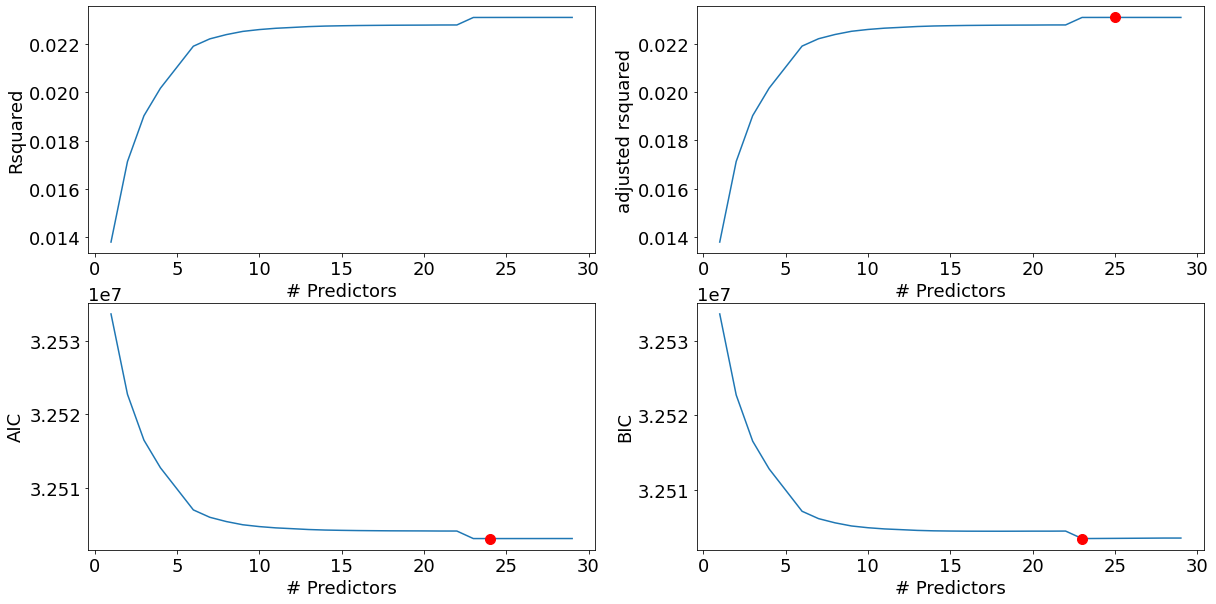

In [ ]:
best_sub_plots()

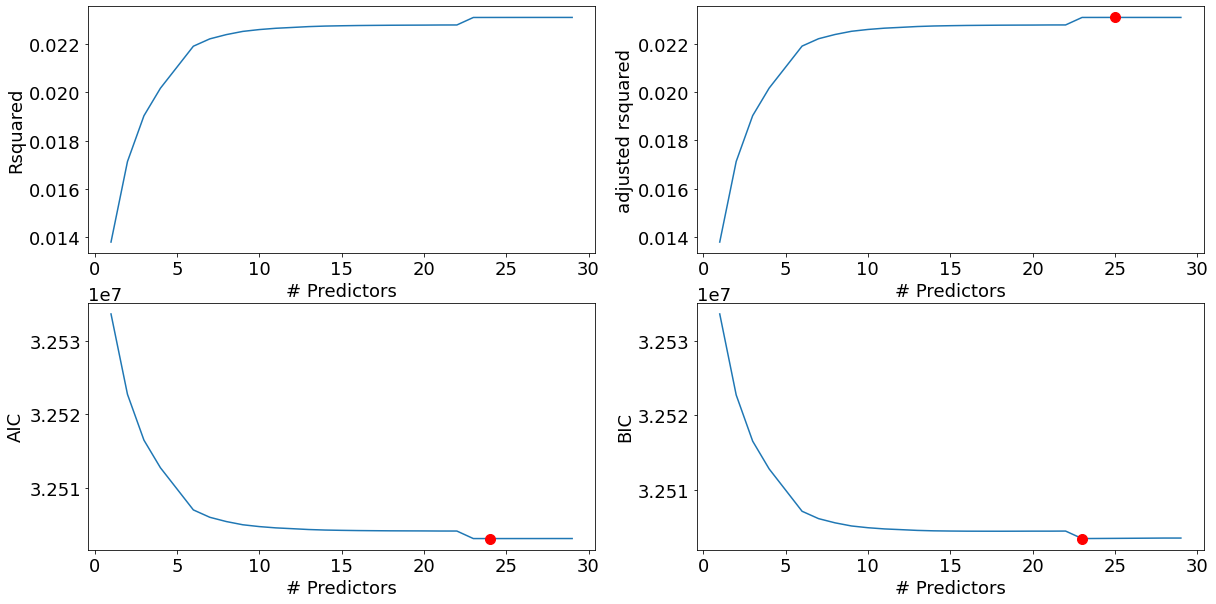

In [ ]:
best_sub_plots()

In [ ]:
# calculate rmse
pred_price = (best_fwd_reg_model.predict(test))
np.sqrt(((pred_price - test.departure_delay)**2).mean())

37.451135927191935

In [ ]:
# model equation
print('departuredelay =')
for i in range(len(X.columns)):
    if best_fwd_reg_model.params[i] != 0:
        print('{:+3f} * {}'.format(best_fwd_reg_model.params[i], X.columns[i]))

departuredelay =
-33.741388 * day
+0.011727 * day_of_week
+0.220948 * destination_latitude
+4.992233 * destination_longitude
-6.550723 * distance
+0.004800 * month
+8.576921 * origin_latitude
-0.341246 * origin_longitude
-1.093841 * scheduled_arrival
+0.068400 * scheduled_departure
-0.043887 * scheduled_time
-0.088616 * taxi_in
+0.011618 * taxi_out
+0.005211 * day_of_year
-1.232661 * origin_temperature
+0.011686 * destination_temperature
+2.039992 * airline_AS
-0.619124 * airline_NK
+0.938315 * airline_UA
-0.000979 * destination_airport_BTV
-0.003979 * destination_airport_DTW
+0.002222 * destination_airport_FNT
+33.207164 * origin_airport_CMH
+1.088528 * origin_airport_IAD


IndexError: index 24 is out of bounds for axis 0 with size 24

### Variable Selection: Backward Selection
*By Haneef Usmani*

We ran backward selection as well, but only on numerical predictors. We were not able to run it on the updated dataset including categorical predicotrs since backward selection was too computationally demanding

In [ ]:
flight = pd.read_csv('flights_clean.csv')

In [ ]:
# split flight into train and test
train, test = train_test_split(flight, test_size=0.2)
# drop all categorical variables from train
train_drop = train.drop(['airline', 'destination_airport', 'origin_airport', 'state_destination', 'state_origin'], axis=1)
X = train[['airline', 'day', 'day_of_week', 'destination_airport', 'destination_latitude', 'destination_longitude', 'distance', 'month', 'origin_airport', 'origin_latitude', 'origin_longitude', 'scheduled_arrival', 'scheduled_departure', 'scheduled_time', 'state_destination', 'state_origin', 'taxi_in', 'taxi_out', 'day_of_year', 'origin_temperature', 'destination_temperature']]
# take out all categorical variables
X = X.drop(['airline', 'destination_airport', 'origin_airport', 'state_destination', 'state_origin'], axis=1)

In [ ]:
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = smf.ols('(departure_delay)~' + '+'.join(predictor_subset),data = train_drop).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [ ]:
def backward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"], index = range(1,len(X.columns)))

    tic = time.time()
    predictors = X.columns
    models_best.loc[len(predictors)] = processSubset(predictors)
    
    while(len(predictors) > 1):  
        models_best.loc[len(predictors)-1] = backward(predictors)
        predictors = models_best.loc[len(predictors)-1]["model"].params.index[1:]

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [ ]:
models_best = backward_selection()

Processed  16 models on 15 predictors in 68.81499290466309 seconds.
Processed  15 models on 14 predictors in 56.42546534538269 seconds.
Processed  14 models on 13 predictors in 52.14179182052612 seconds.
Processed  13 models on 12 predictors in 43.30004858970642 seconds.
Processed  12 models on 11 predictors in 33.920105934143066 seconds.
Processed  11 models on 10 predictors in 39.47048544883728 seconds.
Processed  10 models on 9 predictors in 27.994214296340942 seconds.
Processed  9 models on 8 predictors in 21.299396276474 seconds.
Processed  8 models on 7 predictors in 16.88595151901245 seconds.
Processed  7 models on 6 predictors in 12.681800365447998 seconds.
Processed  6 models on 5 predictors in 9.235478401184082 seconds.
Processed  5 models on 4 predictors in 6.387692451477051 seconds.
Processed  4 models on 3 predictors in 4.12565803527832 seconds.
Processed  3 models on 2 predictors in 2.5801966190338135 seconds.
Processed  2 models on 1 predictors in 1.328359842300415 secon

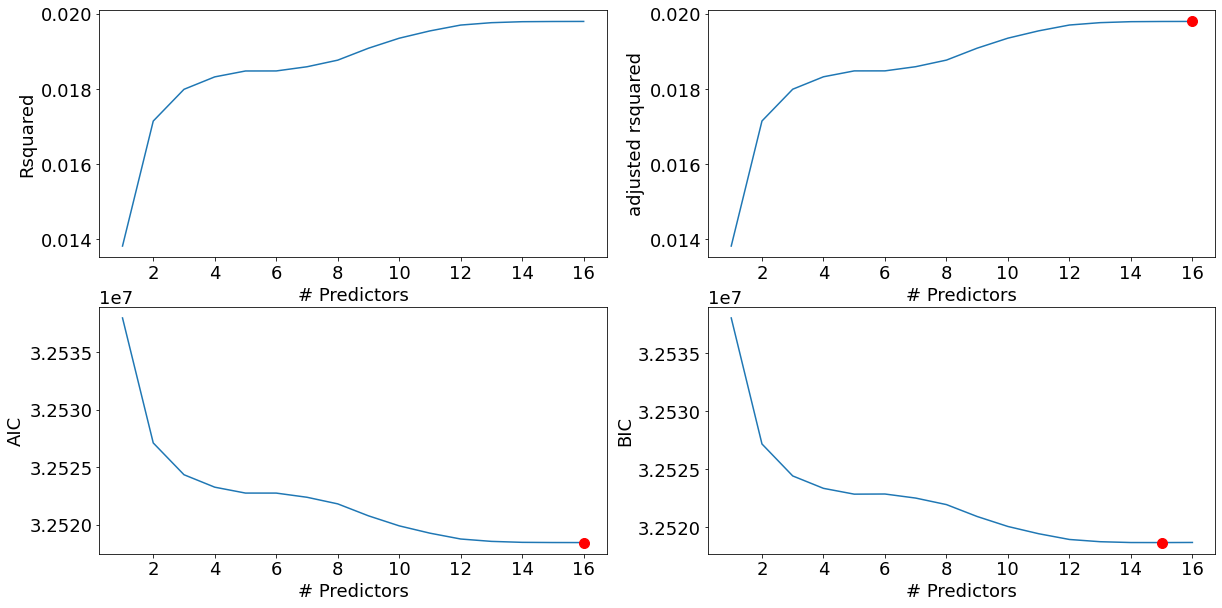

In [ ]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

In [ ]:
best_fwd_reg_model = models_best['model'][16]
best_fwd_reg_model.summary() # same result as forward selection

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        departure_delay   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     4071.
Date:                Sat, 11 Mar 2023   Prob (F-statistic):               0.00
Time:                        21:44:15   Log-Likelihood:            -1.6259e+07
No. Observations:             3225535   AIC:                         3.252e+07
Df Residuals:                 3225518   BIC:                         3.252e+07
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 -29.8504      1.040    -28.702      0.000     -31.889     -27.812
day                         1.1102      0.034     32.600      0.000       1.043       1.177
day_of_week                -0.3560      0.010    -33.986      0.000      -0.377      -0.335
destination_latitude       -0.0424      0.005     -8.525      0.000      -0.052      -0.033
destination_longitude       0.0285      0.002     15.531      0.000       0.025       0.032
distance                   -0.0018      0.000     -5.694      0.000      -0.002      -0.001
month                      33.9070      1.037     32.699      0.000      31.875      35.939
origin_latitude            -0.1277      0.005    -25.711      0.000      -0.137      -0.118
origin_longitude            0.0095      0.002      4.257      0.000       0.005       0.014
scheduled_arrival           0.0045   9.24e-05     48.629      0.000       0.004       0.005
scheduled_departure         0.0120   9.76e-05    123.350      0.000       0.012       0.012
scheduled_time              0.0232      0.003      9.045      0.000       0.018       0.028
taxi_in                     0.0893      0.004     24.031      0.000       0.082       0.097
taxi_out                    0.2205      0.002     92.488      0.000       0.216       0.225
day_of_year                -1.1165      0.034    -32.800      0.000      -1.183      -1.050
origin_temperature         -0.0451      0.002    -22.477      0.000      -0.049      -0.041
destination_temperature    -0.0047      0.002     -2.355      0.019      -0.009      -0.001
==============================================================================
Omnibus:                  4349087.685   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2039839534.607
Skew:                           7.504   Prob(JB):                         0.00
Kurtosis:                     125.280   Cond. No.                     1.11e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# RMSE
pred_price = (best_fwd_reg_model.predict(test))
np.sqrt(((pred_price - test.departure_delay)**2).mean())

37.41356160534415

### Shrinkage Methods: Ridge Regression
*By Ben Caterine*

After performing variable selection, we used shrinkage methods to improve model performance. First was ridge regression.

#### Numerical Data
Perform ridge regression on only numerical columns of data

In [45]:
tic = time.time()

In [138]:
flights = pd.read_csv('data/flights_clean.csv')
flights

,airline,day,day_of_week,departure_delay,destination_airport,destination_latitude,destination_longitude,distance,month,origin_airport,...,scheduled_arrival,scheduled_departure,scheduled_time,state_destination,state_origin,taxi_in,taxi_out,day_of_year,origin_temperature,destination_temperature
0,AS,1,4,-11.0,SEA,47.44898,-122.30931,1448,1,ANC,...,270,5,205.0,WA,AK,4.0,21.0,1,35.2,32.9
1,AS,1,4,-4.0,SEA,47.44898,-122.30931,1448,1,ANC,...,309,45,204.0,WA,AK,4.0,17.0,1,35.2,32.9
2,DL,1,4,-14.0,SEA,47.44898,-122.30931,1448,1,ANC,...,315,45,210.0,WA,AK,4.0,25.0,1,35.2,32.9
3,AS,1,4,-15.0,SEA,47.44898,-122.30931,1448,1,ANC,...,393,115,218.0,WA,AK,11.0,17.0,1,35.2,32.9
4,AS,1,4,-11.0,SEA,47.44898,-122.30931,1448,1,ANC,...,400,140,200.0,WA,AK,8.0,15.0,1,35.2,32.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4031914,EV,27,5,77.0,ROA,37.32547,-79.97543,357,11,ATL,...,648,565,83.0,VA,GA,3.0,9.0,331,59.7,49.4
4031915,EV,27,5,-6.0,ROA,37.32547,-79.97543,357,11,ATL,...,985,902,83.0,VA,GA,5.0,21.0,331,59.7,49.4
4031916,DL,27,5,-1.0,ROA,37.32547,-79.97543,357,11,ATL,...,1162,1079,83.0,VA,GA,6.0,22.0,331,59.7,49.4
4031917,EV,19,6,88.0,ABE,40.65236,-75.44040,692,12,ATL,...,934,821,113.0,PA,GA,3.0,22.0,353,37.8,35.6


In [47]:
flights.iloc[0]

airline                           AS
day                                1
day_of_week                        4
departure_delay                -11.0
destination_airport              SEA
destination_latitude        47.44898
destination_longitude     -122.30931
distance                        1448
month                              1
origin_airport                   ANC
origin_latitude             61.17432
origin_longitude          -149.99619
scheduled_arrival                270
scheduled_departure                5
scheduled_time                 205.0
state_destination                 WA
state_origin                      AK
taxi_in                          4.0
taxi_out                        21.0
day_of_year                        1
origin_temperature              35.2
destination_temperature         32.9
Name: 0, dtype: object

In [48]:
pre_y = flights.departure_delay

In [49]:
pre_X = flights.drop(columns=['departure_delay', 'airline', 'destination_airport',
                              'origin_airport', 'state_destination', 'state_origin'])

In [50]:
X, X_test, y, y_test = train_test_split(pre_X, pre_y)

In [51]:
scaler = StandardScaler()
scaler.fit(X)
Xstd = scaler.transform(X)

In [52]:
alphas = 10**np.linspace(10,-2,200)*0.5

In [53]:
# Find ridge coeffs for all lambda values
coefs = []
for a in alphas:        
    ridge = Ridge(alpha = a)
    ridge.fit(Xstd, y)
    coefs.append(ridge.coef_)

Text(0, 0.5, 'Standardized coefficient')

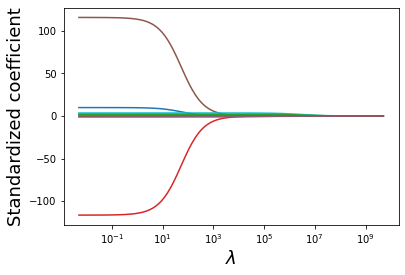

In [54]:
# Visualize shrinking regression coefficients with lambda increase
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')

In [55]:
# Cross validation to find optimal lambda
alphas = 10**np.linspace(2,-2,200)*0.5
ridgecv = RidgeCV(alphas = alphas,store_cv_values=True)
ridgecv.fit(Xstd, y)

#Optimal value of the tuning parameter - lambda
ridgecv.alpha_

0.05058189898831035

Text(0, 0.5, 'Cross-validation error')

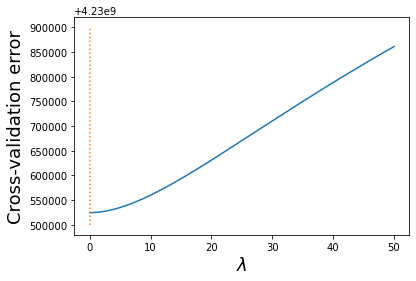

In [81]:
# Visualizing the LOOCV (leave one out cross validatation error vs lambda)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(ridgecv.alphas,ridgecv.cv_values_.sum(axis=0))
plt.plot([ridgecv.alpha_,ridgecv.alpha_],[4e9+2e8+3e7+5e5,4e9+2e8+3e7+9e5],':')
plt.xlabel('$\lambda$')
plt.ylabel('Cross-validation error')

Text(0, 0.5, 'Standardized coefficient')

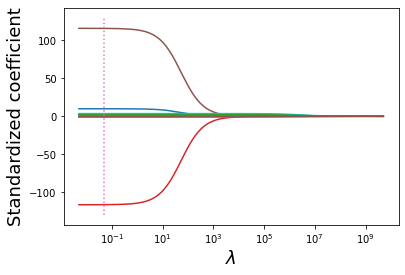

In [57]:
# Visualize with the optimal lambda
alphas = 10**np.linspace(10,-2,200)*0.5
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.plot([ridgecv.alpha_,ridgecv.alpha_],[-130,130],':')
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')

In [58]:
Xtest_std = scaler.transform(X_test)

In [59]:
#Using the developed ridge regression model to predict on test data
ridge = Ridge(alpha = ridgecv.alpha_)
ridge.fit(Xstd, y)
pred=ridge.predict(Xtest_std)

In [60]:
#RMSE on test data
np.sqrt(((pred-y_test)**2).mean())

37.421598050228624

Numerical Ridge RMSE = 37.422

In [61]:
y_test.std()

37.786564055795324

In [62]:
#Checking the coefficients of the ridge regression model
ridge.coef_

array([ 9.87724077e+00, -6.94792171e-01, -2.16567809e-01,  4.56502684e-01,
       -9.51693615e-01,  1.15586349e+02, -6.82920264e-01,  1.61928135e-01,
        1.38702225e+00,  3.52926874e+00,  1.61430974e+00,  5.42189648e-01,
        2.03906877e+00, -1.16264269e+02, -8.47861384e-01, -9.08208039e-02])

In [63]:
#R-squared on train data for the ridge regression model
r2_score(ridge.predict(Xstd),y)

-48.05758260608127

In [64]:
#R-squared on test data for the ridge regression model
r2_score(pred,y_test)

-48.121547722188076

In [65]:
toc = time.time()
toc - tic

163.185124874115

#### Numerical + Categorical Data

Perform ridge regression on all numerical columns plus the categorical columns which were significant at base level. Using all categorical data caused performance issues during variable selection.

In [82]:
tic_dummy = time.time()

In [139]:
flights_numerical = pd.read_csv('data/flights_clean_numerical.csv')
flights_numerical

,day,day_of_week,departure_delay,destination_latitude,destination_longitude,distance,month,origin_latitude,origin_longitude,scheduled_arrival,...,state_origin_SD,state_origin_TN,state_origin_TX,state_origin_UT,state_origin_VA,state_origin_VT,state_origin_WA,state_origin_WI,state_origin_WV,state_origin_WY
0,1,4,-11.0,47.44898,-122.30931,1448,1,61.17432,-149.99619,270,...,0,0,0,0,0,0,0,0,0,0
1,1,4,-4.0,47.44898,-122.30931,1448,1,61.17432,-149.99619,309,...,0,0,0,0,0,0,0,0,0,0
2,1,4,-14.0,47.44898,-122.30931,1448,1,61.17432,-149.99619,315,...,0,0,0,0,0,0,0,0,0,0
3,1,4,-15.0,47.44898,-122.30931,1448,1,61.17432,-149.99619,393,...,0,0,0,0,0,0,0,0,0,0
4,1,4,-11.0,47.44898,-122.30931,1448,1,61.17432,-149.99619,400,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4031914,27,5,77.0,37.32547,-79.97543,357,11,33.64044,-84.42694,648,...,0,0,0,0,0,0,0,0,0,0
4031915,27,5,-6.0,37.32547,-79.97543,357,11,33.64044,-84.42694,985,...,0,0,0,0,0,0,0,0,0,0
4031916,27,5,-1.0,37.32547,-79.97543,357,11,33.64044,-84.42694,1162,...,0,0,0,0,0,0,0,0,0,0
4031917,19,6,88.0,40.65236,-75.44040,692,12,33.64044,-84.42694,934,...,0,0,0,0,0,0,0,0,0,0


In [140]:
columns_subset = \
    list(flights.columns.difference(['airline', 'destination_airport',
                                     'origin_airport', 'state_destination', 'state_origin']))
columns_subset += [
    'airline_AS', 'airline_NK', 'airline_UA',
    'destination_airport_BTV', 'destination_airport_DTW', 'destination_airport_FNT', 
    'origin_airport_CMH', 'origin_airport_IAD', 'origin_airport_LNK', 'origin_airport_RIC',
    'state_destination_MI', 'state_destination_VT', 'state_origin_NE'
]
flights = flights_numerical[columns_subset]

In [141]:
flights.iloc[0]

day                           1.00000
day_of_week                   4.00000
day_of_year                   1.00000
departure_delay             -11.00000
destination_latitude         47.44898
destination_longitude      -122.30931
destination_temperature      32.90000
distance                   1448.00000
month                         1.00000
origin_latitude              61.17432
origin_longitude           -149.99619
origin_temperature           35.20000
scheduled_arrival           270.00000
scheduled_departure           5.00000
scheduled_time              205.00000
taxi_in                       4.00000
taxi_out                     21.00000
airline_AS                    1.00000
airline_NK                    0.00000
airline_UA                    0.00000
destination_airport_BTV       0.00000
destination_airport_DTW       0.00000
destination_airport_FNT       0.00000
origin_airport_CMH            0.00000
origin_airport_IAD            0.00000
origin_airport_LNK            0.00000
origin_airpo

In [142]:
pre_y = flights.departure_delay

In [143]:
pre_X = flights.drop(columns=['departure_delay'])

In [144]:
X, X_test, y, y_test = train_test_split(pre_X, pre_y)

In [145]:
scaler = StandardScaler()
scaler.fit(X)
Xstd = scaler.transform(X)

In [146]:
alphas = 10**np.linspace(10,-2,200)*0.5

In [147]:
# Find ridge coeffs for all lambda values
coefs = []
for a in alphas:        
    ridge = Ridge(alpha = a)
    ridge.fit(Xstd, y)
    coefs.append(ridge.coef_)

Text(0, 0.5, 'Standardized coefficient')

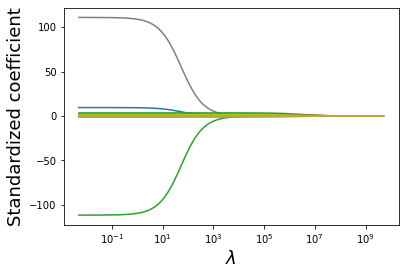

In [148]:
# Visualize shrinking regression coefficients with lambda increase
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')

In [149]:
# Cross validation to find optimal lambda
alphas = 10**np.linspace(5,-2,200)*0.5
ridgecv = RidgeCV(alphas = alphas,store_cv_values=True)
ridgecv.fit(Xstd, y)

#Optimal value of the tuning parameter - lambda
ridgecv.alpha_

0.05678666791715526

Text(0, 0.5, 'Cross-validation error')

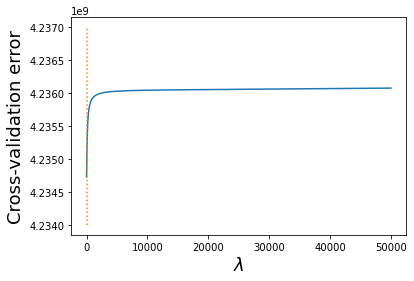

In [167]:
#Visualizing the LOOCV (leave one out cross validatation error vs lambda)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(ridgecv.alphas,ridgecv.cv_values_.sum(axis=0))
plt.plot([ridgecv.alpha_,ridgecv.alpha_],[4e9+2e8+3e7+4e6,4e9+2e8+3e7+7e6],':')
plt.xlabel('$\lambda$')
plt.ylabel('Cross-validation error')

Text(0, 0.5, 'Standardized coefficient')

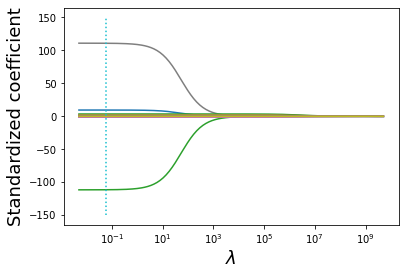

In [151]:
# Visualize with the optimal lambda
alphas = 10**np.linspace(10,-2,200)*0.5
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.plot([ridgecv.alpha_,ridgecv.alpha_],[-150,150],':')
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')

In [152]:
Xtest_std = scaler.transform(X_test)

In [153]:
#Using the developed ridge regression model to predict on test data
ridge = Ridge(alpha = ridgecv.alpha_)
ridge.fit(Xstd, y)
pred=ridge.predict(Xtest_std)

In [154]:
#RMSE on test data
np.sqrt(((pred-y_test)**2).mean())

37.11052273216127

Numerical + Categorical Ridge RMSE = 37.111

In [155]:
y_test.std()

37.54673725524366

In [156]:
#Checking the coefficients of the ridge regression model
#ridge.coef_

In [157]:
#R-squared on train data for the ridge regression model
r2_score(ridge.predict(Xstd),y)

-41.22659747836519

In [158]:
#R-squared on test data for the ridge regression model
r2_score(pred,y_test)

-40.56369481199305

In [159]:
toc_dummy = time.time()
toc_dummy - tic_dummy

12143.176284074783

### Shrinkage Methods: Lasso Regression
*By Ben Caterine*

Since ridge regression did not greatly improve the RMSE of the model in either case, we moved to lasso regression since it will completely remove insignificant predictors (coefficient goes to 0).

#### Numerical Data
Perform lasso regression on only numerical columns of data

In [2]:
tic = time.time()

In [3]:
flights = pd.read_csv('data/flights_clean.csv').sample(10000)
flights

,airline,day,day_of_week,departure_delay,destination_airport,destination_latitude,destination_longitude,distance,month,origin_airport,...,scheduled_arrival,scheduled_departure,scheduled_time,state_destination,state_origin,taxi_in,taxi_out,day_of_year,origin_temperature,destination_temperature
3682225,EV,27,1,-6.0,JAX,30.49406,-81.68786,833,7,LGA,...,972,809,163.0,FL,NY,8.0,19.0,208,79.9,80.3
3322949,DL,25,3,-5.0,SFO,37.61900,-122.37484,2586,11,JFK,...,901,690,391.0,CA,NY,5.0,28.0,329,44.0,48.8
1472437,UA,21,3,7.0,SLC,40.78839,-111.97777,391,1,DEN,...,596,502,94.0,UT,CO,9.0,38.0,21,29.4,32.7
3026747,WN,13,7,3.0,MCI,39.29761,-94.71391,460,9,DAL,...,625,540,85.0,MO,TX,5.0,9.0,256,76.5,62.5
653748,OO,6,1,-8.0,DEN,39.85841,-104.66700,844,7,FAT,...,800,598,142.0,CO,CA,5.0,12.0,187,82.7,63.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2994986,B6,8,2,-5.0,BWI,39.17540,-76.66820,369,9,BOS,...,1260,1165,95.0,MD,MA,6.0,16.0,251,81.2,79.6
3957786,EV,22,3,4.0,TYS,35.81249,-83.99286,475,7,ORD,...,669,510,99.0,TN,IL,7.0,20.0,203,73.6,79.2
3433614,WN,10,4,4.0,SLC,40.78839,-111.97777,368,12,LAS,...,855,715,80.0,UT,NV,6.0,14.0,344,52.1,47.1
3584947,WN,19,1,-1.0,LAX,33.94254,-118.40807,337,1,SFO,...,555,470,85.0,CA,CA,24.0,9.0,19,57.1,58.0


In [4]:
pre_y = flights.departure_delay

In [5]:
# drop categorical columns
pre_X = flights.drop(columns=['departure_delay', 'airline', 'destination_airport',
                              'origin_airport', 'state_destination', 'state_origin'])

In [6]:
X, X_test, y, y_test = train_test_split(pre_X, pre_y)

In [7]:
scaler = StandardScaler()
scaler.fit(X)
Xstd = scaler.transform(X)

In [8]:
#Creating a range of values of the tuning parameter to visualize the lasso coefficients
#for different values of the tuning parameter
alphas = 10**np.linspace(10,-2,100)*0.1

In [ ]:
#Finding the lasso coefficients for increasing values of the tuning parameter
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xstd, y)
    coefs.append(lasso.coef_)

Text(0, 0.5, 'Standardized coefficient')

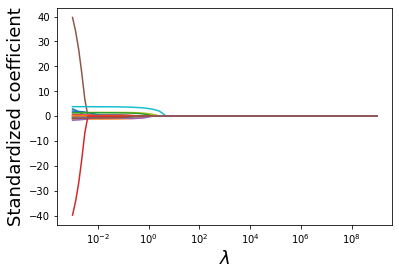

In [10]:
#Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
#plt.plot([lassocv.alpha_,lassocv.alpha_],[-0.4,0.25],':')

In [11]:
#Let us use cross validation to find the optimal value of the tuning parameter - lambda
#For the optimal lambda, the cross validation error will be the least

#Note that we are reducing the range of alpha so as to better visualize the minimum
alphas = 10**np.linspace(1,-5,200)*0.5
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000)
lassocv.fit(Xstd, y)

#Optimal value of the tuning parameter - lamda
lassocv.alpha_

0.5811612343399264

Text(0, 0.5, 'Cross-validation error')

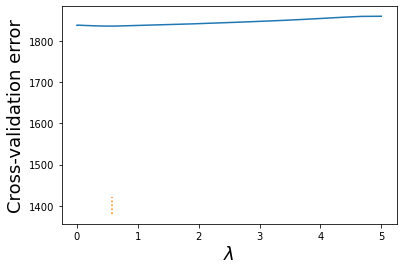

In [12]:
#Visualizing the LOOCV (leave one out cross validatation error vs lambda)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(lassocv.alphas_,lassocv.mse_path_.mean(axis=1))
plt.plot([lassocv.alpha_,lassocv.alpha_],[1380,1420],':')
plt.xlabel('$\lambda$')
plt.ylabel('Cross-validation error')

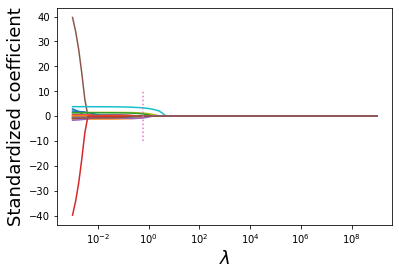

In [13]:
#Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda
alphas = 10**np.linspace(10,-2,100)*0.1
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.plot([lassocv.alpha_,lassocv.alpha_],[-10,10],':')

In [14]:
Xtest_std = scaler.transform(X_test)

In [15]:
#Using the developed lasso model to predict on test data
lasso = Lasso(alpha = lassocv.alpha_)
lasso.fit(Xstd, y)
pred=lasso.predict(Xtest_std)

In [16]:
#RMSE on test data
np.sqrt(((pred-y_test)**2).mean())

41.0926040175769

Numerical Lasso RMSE = 41.093

In [17]:
y_test.std()

41.4815275395063

In [18]:
toc = time.time()
toc - tic

48.57084631919861

#### Numerical + Categorical + Variable Transformations
Perform lasso regression on all numerical columns plus the categorical columns which were significant at base level. Using all categorical data caused performance issues during variable selection. We also added variable transformations to this model to further improve performance.

In [303]:
tic_dummy = time.time()

In [304]:
flights = pd.read_csv('data/flights_clean_numerical_significant.csv').sample(10000)
flights

,day,day_of_week,day_of_year,departure_delay,destination_latitude,destination_longitude,destination_temperature,distance,month,origin_latitude,...,destination_airport_BTV,destination_airport_DTW,destination_airport_FNT,origin_airport_CMH,origin_airport_IAD,origin_airport_LNK,origin_airport_RIC,state_destination_MI,state_destination_VT,state_origin_NE
2649321,9,4,190,-6.0,38.74769,-90.35999,68.8,882,7,28.42889,...,0,0,0,0,0,0,0,0,0,0
1146234,9,1,313,4.0,41.97960,-87.90446,41.7,286,11,38.17439,...,0,0,0,0,0,0,0,0,0,0
731811,19,7,200,5.0,33.43417,-112.00806,83.9,2917,7,21.31869,...,0,0,0,0,0,0,0,0,0,0
3797474,20,1,201,-3.0,42.88082,-85.52277,71.9,640,7,33.64044,...,0,0,0,0,0,0,0,1,0,0
130330,6,5,65,32.0,33.43417,-112.00806,65.8,370,3,33.94254,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3284915,19,4,323,-4.0,42.21206,-83.34884,54.9,166,11,39.90238,...,0,1,0,0,0,0,0,1,0,0
2180831,24,5,114,-3.0,39.87195,-75.24114,46.5,678,4,41.97960,...,0,0,0,0,0,0,0,0,0,0
3458217,13,7,347,-1.0,28.42889,-81.31603,70.5,787,12,39.17540,...,0,0,0,0,0,0,0,0,0,0
3396687,5,6,339,-4.0,29.98047,-95.33972,48.2,854,12,28.42889,...,0,0,0,0,0,0,0,0,0,0


Add variable transformations and binned variables to the data (binned as dummy columns):\
This is based on the insights discovered during EDA.

In [305]:
flights['log_distance'] = np.log(flights.distance)
flights['log_scheduled_time'] = np.log(flights.scheduled_time)
flights['log_taxi_in'] = np.log(flights.taxi_in)
flights['log_taxi_out'] = np.log(flights.taxi_out)

flights = pd.concat([flights, pd.get_dummies(pd.cut(flights.destination_latitude, 4),
                                             prefix='destination_latitude')], axis=1)
flights = pd.concat([flights, pd.get_dummies(pd.cut(flights.destination_longitude, 4),
                                             prefix='destination_longitude')], axis=1)
flights = pd.concat([flights, pd.get_dummies(pd.cut(flights.origin_latitude, 4),
                                             prefix='origin_latitude')], axis=1)
flights = pd.concat([flights, pd.get_dummies(pd.cut(flights.origin_longitude, 4),
                                             prefix='origin_longitude')], axis=1)

flights = pd.concat([flights, pd.get_dummies(pd.cut(flights.day_of_year, 8), prefix='day_of_year')], axis=1)

In [306]:
pre_y = flights.departure_delay

In [307]:
pre_X = flights.drop(columns=['departure_delay'])

In [308]:
X, X_test, y, y_test = train_test_split(pre_X, pre_y)

In [309]:
scaler = StandardScaler()
scaler.fit(X)
Xstd = scaler.transform(X)

In [310]:
#Creating a range of values of the tuning parameter to visualize the lasso coefficients
#for different values of the tuning parameter
alphas = 10**np.linspace(10,-2,100)*0.1

In [311]:
#Finding the lasso coefficients for increasing values of the tuning parameter
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xstd, y)
    coefs.append(lasso.coef_)

Text(0, 0.5, 'Standardized coefficient')

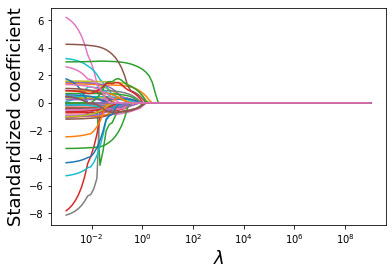

In [312]:
#Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
#plt.plot([lassocv.alpha_,lassocv.alpha_],[-0.4,0.25],':')

In [ ]:
#Let us use cross validation to find the optimal value of the tuning parameter - lambda
#For the optimal lambda, the cross validation error will be the least

#Note that we are reducing the range of alpha so as to better visualize the minimum
alphas = 10**np.linspace(1,-5,200)*0.5
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000)
lassocv.fit(Xstd, y)

#Optimal value of the tuning parameter - lamda
lassocv.alpha_

Text(0, 0.5, 'Cross-validation error')

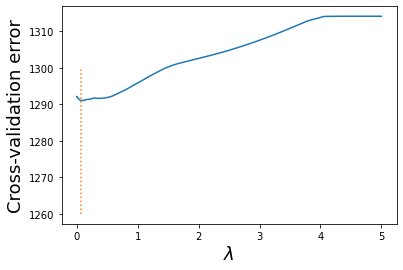

In [314]:
#Visualizing the LOOCV (leave one out cross validatation error vs lambda)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(lassocv.alphas_,lassocv.mse_path_.mean(axis=1))
plt.plot([lassocv.alpha_,lassocv.alpha_],[1260,1300],':')
plt.xlabel('$\lambda$')
plt.ylabel('Cross-validation error')

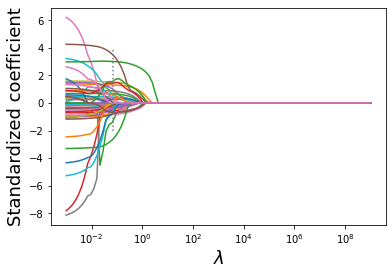

In [315]:
#Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda
alphas = 10**np.linspace(10,-2,100)*0.1
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.plot([lassocv.alpha_,lassocv.alpha_],[-2,4],':')

In [316]:
Xtest_std = scaler.transform(X_test)

In [317]:
#Using the developed lasso model to predict on test data
lasso = Lasso(alpha = lassocv.alpha_)
lasso.fit(Xstd, y)
pred=lasso.predict(Xtest_std)

In [318]:
#RMSE on test data
np.sqrt(((pred-y_test)**2).mean())

34.526217933807565

Numerical + Select Categorical + Variable Transformations Lasso RMSE = 34.526\

This model is our best performing model based on RMSE.

In [319]:
y_test.std()

35.09391640366495

In [320]:
toc_dummy = time.time()
toc_dummy - tic_dummy

228.10442328453064

### Code fitting the final model

Our current best model was the one produced by lasso regression on all numerical variables, significant categorical levels, and transformed/binned variables. It was fitted above but is copied here:

In [311]:
#Finding the lasso coefficients for increasing values of the tuning parameter
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xstd, y)
    coefs.append(lasso.coef_)

In [ ]:
lasso.coef_#Let us use cross validation to find the optimal value of the tuning parameter - lambda
#For the optimal lambda, the cross validation error will be the least

#Note that we are reducing the range of alpha so as to better visualize the minimum
alphas = 10**np.linspace(1,-5,200)*0.5
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000)
lassocv.fit(Xstd, y)

#Optimal value of the tuning parameter - lamda
lassocv.alpha_

In [321]:
lasso.coef_

array([-2.80061930e-01, -4.10926826e-01, -1.40843497e+00,  0.00000000e+00,
        0.00000000e+00, -4.76173587e-01, -0.00000000e+00, -0.00000000e+00,
        8.38358183e-01,  5.92645776e-01, -4.79042507e-01,  1.29589274e+00,
        3.00756180e+00, -0.00000000e+00,  1.01639522e+00,  3.50971473e+00,
       -8.32837212e-01,  8.72424457e-01,  1.50934434e+00,  4.26375565e-01,
       -8.11656998e-02, -2.40463937e-01,  6.60775111e-01, -5.88642593e-01,
       -3.84632347e-01, -2.94619246e-01, -4.43162295e-01,  7.49645049e-05,
        3.53779345e-01,  3.61776499e-01, -0.00000000e+00, -6.22059529e-01,
       -2.65184127e+00, -0.00000000e+00,  3.16994370e-01, -8.06106279e-01,
       -0.00000000e+00, -1.21631796e-01,  0.00000000e+00, -2.67982897e-01,
        2.39961868e-01,  6.05813743e-01,  0.00000000e+00, -1.92634471e-01,
       -3.95085289e-01,  5.57422955e-02,  3.38428175e-01, -0.00000000e+00,
       -0.00000000e+00, -8.07627208e-01, -8.05485456e-01,  0.00000000e+00,
        1.53883010e+00,  

Final regression equation:

In [322]:
print('departure_delay =')
for i in range(len(X.columns)):
    if lasso.coef_[i] != 0:
        print('{:+3f} * {}'.format(lasso.coef_[i], X.columns[i]))

departure_delay =
-0.280062 * day
-0.410927 * day_of_week
-1.408435 * day_of_year
-0.476174 * destination_temperature
+0.838358 * origin_latitude
+0.592646 * origin_longitude
-0.479043 * origin_temperature
+1.295893 * scheduled_arrival
+3.007562 * scheduled_departure
+1.016395 * taxi_in
+3.509715 * taxi_out
-0.832837 * airline_AS
+0.872424 * airline_NK
+1.509344 * airline_UA
+0.426376 * destination_airport_BTV
-0.081166 * destination_airport_DTW
-0.240464 * destination_airport_FNT
+0.660775 * origin_airport_CMH
-0.588643 * origin_airport_IAD
-0.384632 * origin_airport_LNK
-0.294619 * origin_airport_RIC
-0.443162 * state_destination_MI
+0.000075 * state_destination_VT
+0.353779 * state_origin_NE
+0.361776 * log_distance
-0.622060 * log_taxi_in
-2.651841 * log_taxi_out
+0.316994 * destination_latitude_(32.192, 43.066]
-0.806106 * destination_latitude_(43.066, 53.94]
-0.121632 * destination_longitude_(-158.01, -136.019]
-0.267983 * destination_longitude_(-114.116, -92.212]
+0.239962 * des